In [ ]:
library(rio)
library(tidyverse)
library(ggtern)
library(smwrGraphs)

In [2]:
PROJECT_NAME = "arg23"

DATA_DIR = file.path(
    "../data/",
    PROJECT_NAME
)

## Decription of the input files

* **DIC data** - *ARG23.xlsx*

* **IC data** - *Anioni_Cationi_ARG23.xlsx*

* **ICP-MS data** - *ARG23_dil1at10.xlsx*

## DIC analysis

In [3]:
dic_df = import(
    file=file.path(
        DATA_DIR,
        "ARG23.xlsx"
    ),
    skip=4
)

dic_df = dic_df %>%
    # Drop NA rows
    drop_na(Name) %>%
    # Format "Sample Type"
    mutate(`Sample Type`=str_replace_all(
            string=`Sample Type`,
            pattern="\\(|\\)",
            replacement=""
        )
    ) %>%
    # Convert to numeric
    mutate(
        `Height (nA)`=as.numeric(`Height (nA)`),
        `δ¹³C (Gas)`=as.numeric(`δ¹³C (Gas)`)
    ) %>%
    # Group by name and calculate the mean
    group_by(Name) %>%
    summarise(
        Height_mean=mean(`Height (nA)`),
        DeltaC13_mean=mean(`δ¹³C (Gas)`),
        DeltaC13_sd=sd(`δ¹³C (Gas)`) # TODO: check use of SE
    )

dic_df = dic_df %>%
    # Natural sort by name
    slice(stringr::str_order(dic_df$Name, numeric=TRUE)) %>%
    # Transform to factor for plotting the samples in the correct order
    mutate(Name=factor(Name, levels=Name))

dic_df

Name,Height_mean,DeltaC13_mean,DeltaC13_sd
<fct>,<dbl>,<dbl>,<dbl>
ARG23_1,6.4190218,-3.4409935,0.1359016
ARG23_2,4.0301275,-5.5271253,0.2716068
ARG23_3,5.4543274,-3.1768285,0.8068695
ARG23_4,3.5758961,-9.9798606,0.4742499
ARG23_5,1.8756161,-5.9922322,0.7973183
ARG23_6,12.8719853,-2.6227354,0.5387774
ARG23_7,1.4093049,-6.6174893,0.7180623
ARG23_8,4.7544556,-5.8113600,0.2032612
ARG23_9,2.6648682,-4.2482822,0.1525767


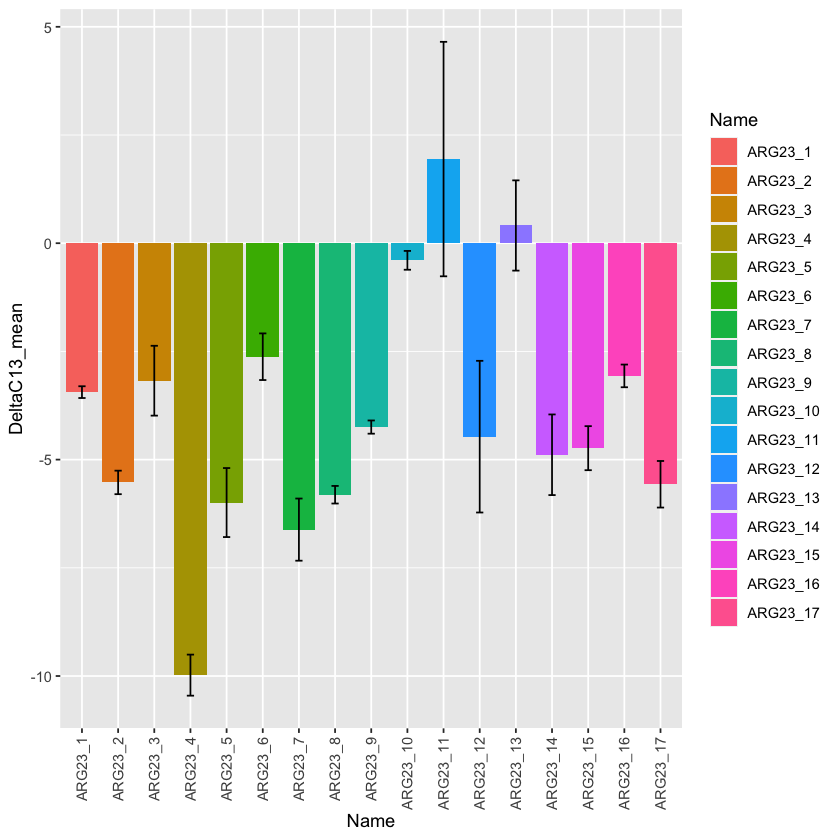

In [4]:
plot_dic = ggplot(
        data=dic_df,
        aes(
            x=Name,
            y=DeltaC13_mean,
            fill=Name
        )
    ) +
    geom_col() +
    geom_errorbar(
        aes(
            ymin=DeltaC13_mean - DeltaC13_sd,
            ymax=DeltaC13_mean + DeltaC13_sd
        ),
        width=.2
    ) +
    # Rotate X axis labels
    theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1))

plot_dic

## IC analysis

In [5]:
ic_df = import(
    file=file.path(
        DATA_DIR,
        "Anioni_Cationi_ARG23.xlsx"
    )
)

ic_df = ic_df %>%
    # Remove controls
    drop_na(Expedition) %>%
    # Remove time column
    select(-`Determination start`)

# Merge anions and cations (see https://stackoverflow.com/a/45518649)
ic_df = ic_df %>%
    group_by(Ident) %>%
    fill(everything(), .direction = "downup") %>%
    slice(1)

In [6]:
# Rename columns (see https://stackoverflow.com/a/23518906)

# Create the mapping for renaming the columns
ic_columns_map = as.vector(colnames(ic_df))
names(ic_columns_map) = str_extract(
    string=colnames(ic_df),
    pattern="(?<=[Anions|Cations]\\.)(.+)(?=\\.Concentration)"
)

# Deselect the original columns
ic_columns_map = ic_columns_map[!is.na(names(ic_columns_map))]

# Finally, rename the columns using the mapping
ic_df = ic_df %>%
    rename(all_of(ic_columns_map))

ic_df

Ident,Expedition,Dilution,Chloride,Nitrite,Bromide,Nitrate,Phosphate,Sulfate,Sodium,Ammonium,Potassium,Magnesium,Calcium
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LB,ARG23,1954.90,7950.703,NA,NA,2197296.00,NA,2121.135,5372.504,87.938,434.672,52.737,279.845
LV,ARG23,3863.25,22813.620,NA,NA,2070508.00,NA,3553.992,12257.730,214.816,1652.636,896.096,1327.956
OY,ARG23,20.18,86.709,NA,NA,13386.74,NA,348.986,154.226,1.182,3.939,6.791,13.944
PI,ARG23,1991.83,7571.802,NA,NA,2278402.00,NA,709.547,5223.494,69.399,424.462,139.712,296.258
VA,ARG23,19.79,8.021,3.593,NA,13832.41,NA,242.493,12.587,0.803,7.134,14.733,18.100


In [7]:
plot_base_gigg = function() {

    # Giggenbach values
    gigg_df = read.csv(
        text="Temperature,Sodium,Potassium,Magnesium,TK
        20,97900,100,109880,tkn
        40,48759,100,12035,tkn
        60,26404,100,1719,tkn
        80,15327,100,306.1,tkn
        100,9431,100,65.6,tkn
        120,6097,100,16.43,tkn
        140,4111,100,4.708,tkn
        160,2885,100,1.514,tkn
        180,2075,100,0.538,tkn
        200,1540,100,0.209,tkn
        220,1170,100,0.0874,tkn
        240,909,100,0.0392,tkn
        260,719,100,0.0187,tkn
        280,579,100,0.0094,tkn
        300,473,100,0.0049,tkn
        320,392,100,0.0027,tkn
        340,329,100,0.0016,tkn
        20,1000,4.6913698876916,243.272178434398,tkm
        40,1000,9.41774637025521,107.30054996903,tkm
        60,1000,17.3882806494252,52.2148201661805,tkm
        80,1000,29.9503828726739,27.5686978576995,tkm
        100,1000,48.6669754009193,15.5873520225527,tkm
        120,1000,75.268939223164,9.3395145645343,tkm
        140,1000,111.599401662987,5.88048364057256,tkm
        160,1000,159.555722917517,3.86416170872552,tkm
        180,1000,221.033850062941,2.63508384781384,tkm
        200,1000,297.878314852584,1.85604816590842,tkm
        220,1000,391.839837478812,1.34502264255868,tkm
        240,1000,504.541406799503,0.999475140308976,tkm
        260,1000,637.452885775713,0.759433137206677,tkm
        280,1000,791.873628347427,0.588616966121383,tkm
        300,1000,968.922251313534,0.464406957635952,tkm
        320,1000,1169.53253313088,0.372311266745217,tkm
        340,1000,1394.45436354981,0.302813961608541,tkm"
    )

    # Create plot
    plot = ggtern(
        data=gigg_df,
        aes(
            x=Potassium/100,
            y=Sodium/1000,
            z=sqrt(Magnesium)
        )
    ) +
    # tern_limit(T=1.03, L=1.03, R=1.03)

    # Create the guides and labels
    guides(fill=guide_legend(override.aes=list(shape=21))) +
    labs(
        x="K/100",
        y="Na/1000",
        z=expression(sqrt(Mg)),
        fill="samples"
    ) +

    # Create the first half of the temperature curves
    geom_point(
        data=gigg_df %>% filter(TK %in% c("tkn")),
        size=1,
        shape=22,
        fill="black",
        stroke=.3
    ) +
    geom_text(
        data=gigg_df %>% filter(TK %in% c("tkn")),
        mapping=aes(label=as.factor(Temperature)),
        color="black",
        size=2.5,
        hjust=0.5,
        vjust=-1
    ) +

    # Create the second half of the temperature curves
    geom_point(
        data=gigg_df %>% filter(TK %in% c("tkm")),
        size=1,
        shape=22,
        fill="black",
        stroke=.3
    ) +
    geom_text(
        data=gigg_df %>% filter(TK %in% c("tkm")),
        mapping=aes(label=as.factor(Temperature)),
        color="black",
        size=2.5,
        hjust=0.5,
        vjust=2
    ) +

    # Add annotations
    annotate(
        "text",
        label="Fully Equilibrated",
        x=0.2,
        y=0.8,
        z=0.2,
        size=6,
        alpha=.5,
        fontface="bold"
    ) +
    annotate(
        "text",
        label="Partially Equilibrated",
        x=0.2,
        y=0.225,
        z=0.2,
        size=6,
        alpha=.5,
        fontface="bold"
    ) +
    annotate(
        "text",
        label="Immature Waters",
        x=0.2,
        y=0.05,
        z=0.2,
        size=6,
        alpha=.5,
        fontface="bold"
    ) +

    # Modify theme
    theme_hidemask() +
    theme_bw(base_size=25) +
    theme_hidegrid_major() +
    theme_nogrid_minor() +
    theme_nomask()

    return(plot)
}

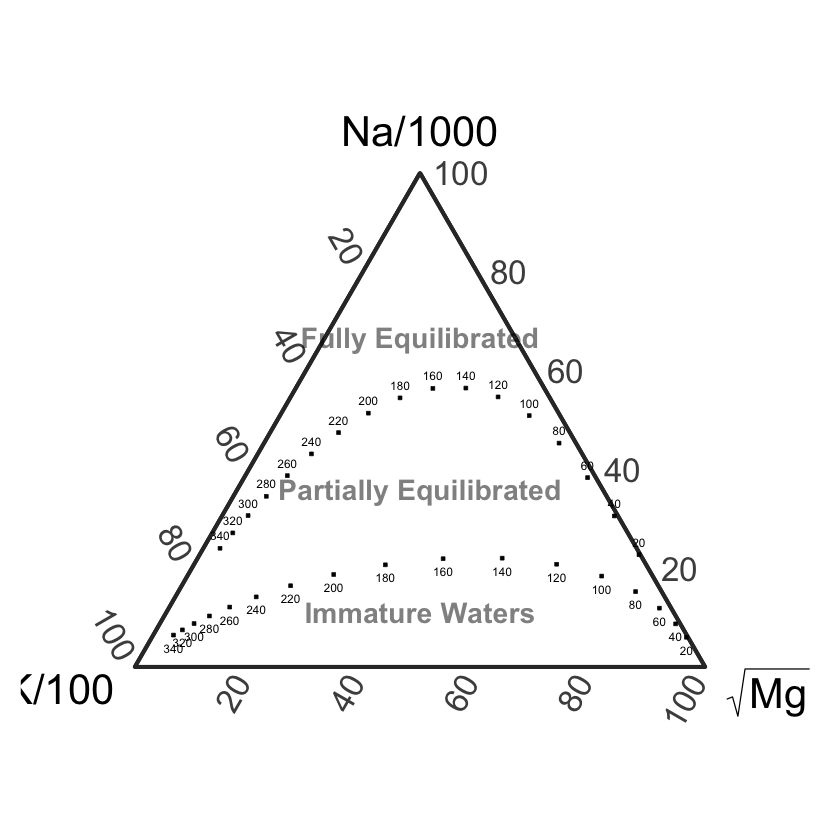

In [8]:
plot_base_gigg()

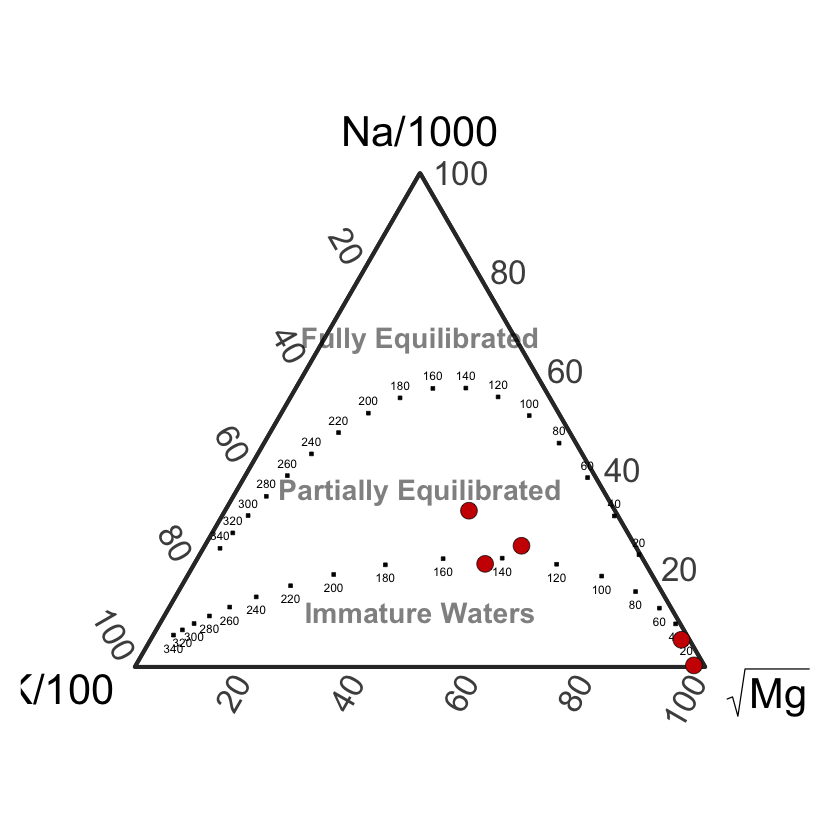

In [9]:
plot_base_gigg() +
    geom_point(
        data=ic_df,
        size=4.5,
        shape=21,
        fill="red3",
        stroke=.3
    )

## ICP-MS analysis

In [ ]:
icp_df = import(
    file=file.path(
        DATA_DIR,
        "ARG23_dil1at10.xlsx"
    )
)